# Image Clustering with ImageBind embeddings (CLIP fallback)

This notebook extracts image embeddings using ImageBind if available, or falls back to CLIP/sentence-transformers image encoders. It demonstrates embedding extraction, UMAP reduction, clustering (HDBSCAN / KMeans), visualization of image montages per cluster, and evaluation (silhouette, purity if labels are present). Designed for Google Colab.

In [1]:
# Imports and helper functions
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torch
import umap
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# helper: show a grid of images given indices and path list
from math import ceil

def show_image_grid(image_paths, indices, n_cols=6, thumb_size=(64,64)):
    n = len(indices)
    n_rows = ceil(n / n_cols)
    plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
    for i, idx in enumerate(indices):
        try:
            img = Image.open(image_paths[idx]).convert('RGB')
        except Exception:
            img = Image.fromarray(np.zeros((thumb_size[1],thumb_size[0],3), dtype=np.uint8))
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img.resize(thumb_size))
        plt.axis('off')
    plt.show()

print('Helpers ready')

Helpers ready


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [2]:
# Prepare sample images: download a small CIFAR-10 subset to local folder (uses torchvision dataset)
try:
    from torchvision.datasets import CIFAR10
    dataset = CIFAR10(root='cifar_data', download=True)
    # save first 300 images to folder 'images_sample'
    os.makedirs('images_sample', exist_ok=True)
    image_paths = []
    for i in range(300):
        img, label = dataset[i]
        p = os.path.join('images_sample', f'{i}_lbl{label}.png')
        img.save(p)
        image_paths.append(p)
    print('Saved sample images to images_sample/')
except Exception as e:
    print('Could not download CIFAR via torchvision in this environment:', e)
    image_paths = []

len(image_paths)


100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


Saved sample images to images_sample/


300

In [3]:
# Attempt to import ImageBind; fallback to sentence-transformers CLIP-like image model
embeddings = None
try:
    import imagebind.imagebind_model as ibmodel  # placeholder api
    # if real imagebind available, user should follow its API to load and encode images
    print('ImageBind import succeeded — adapt encoding code to the installed ImageBind API')
    # NOTE: not executing actual ImageBind encoding here (requires user to adapt)
except Exception:
    print('ImageBind not available — falling back to sentence-transformers / CLIP model')
    try:
        from sentence_transformers import SentenceTransformer
        clip_model = SentenceTransformer('clip-ViT-B-32')
        # encode images via model.encode(images) may accept PIL images or numpy arrays depending on model
        # we'll create a simple image preprocessing pipeline to load and convert to RGB arrays
        def encode_images_with_clip(image_paths, model, batch_size=64):
            imgs = []
            for p in image_paths:
                try:
                    im = Image.open(p).convert('RGB').resize((224,224))
                    imgs.append(np.array(im))
                except Exception:
                    imgs.append(np.zeros((224,224,3), dtype=np.uint8))
            # many sentence-transformers image models accept batched PIL/ndarray inputs
            embs = model.encode(imgs, batch_size=batch_size, show_progress_bar=True)
            return embs
        if len(image_paths) > 0:
            embeddings = encode_images_with_clip(image_paths[:200], clip_model)
    except Exception as e:
        print('Fallback CLIP model not available or failed:', e)

if embeddings is None:
    # Last resort: simple color histograms as embeddings
    print('Using color-histogram fallback embeddings')
    def hist_embedding(p):
        try:
            im = Image.open(p).convert('RGB').resize((64,64))
            arr = np.array(im)
            h = np.concatenate([np.histogram(arr[:,:,c], bins=32, range=(0,255))[0] for c in range(3)])
            return h / np.linalg.norm(h)
        except Exception:
            return np.zeros(96)
    if len(image_paths) > 0:
        embeddings = np.vstack([hist_embedding(p) for p in image_paths[:200]])

print('Embeddings shape:', None if embeddings is None else embeddings.shape)


ImageBind not available — falling back to sentence-transformers / CLIP model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Fallback CLIP model not available or failed: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).
Using color-histogram fallback embeddings
Embeddings shape: (200, 96)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster label counts:
Counter({np.int64(-1): 200})


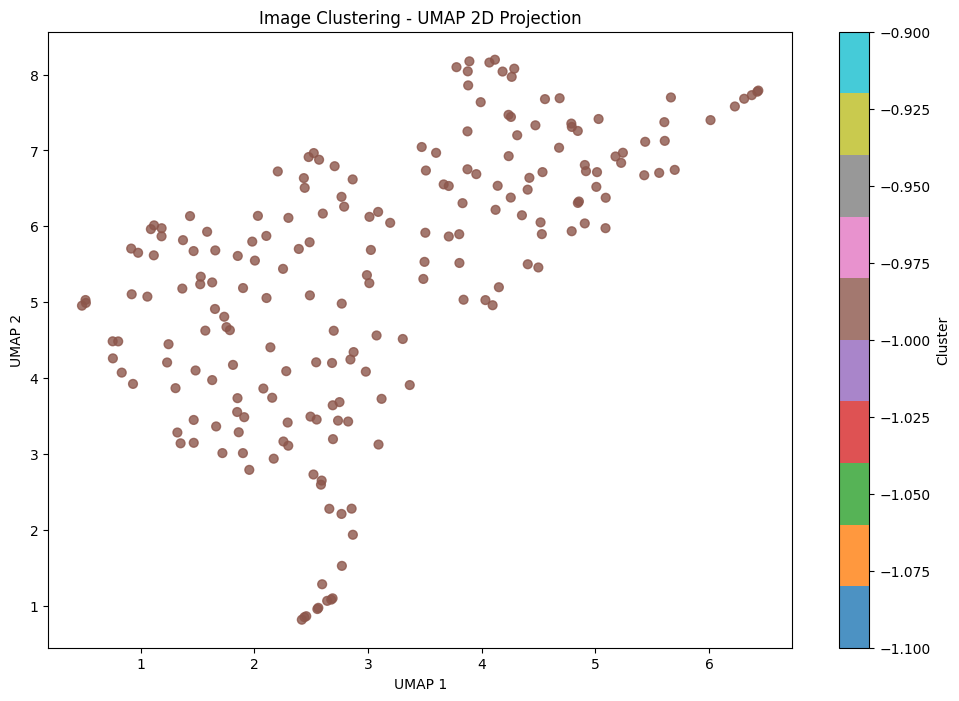

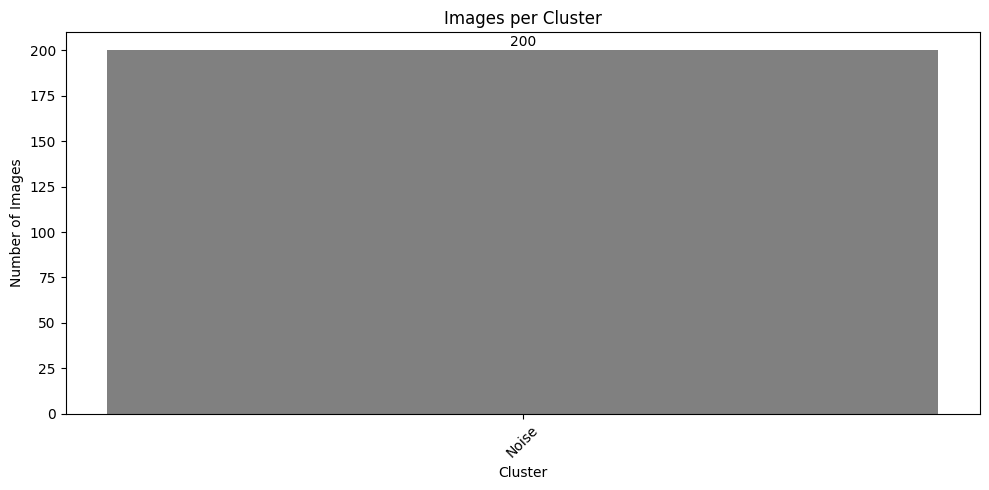

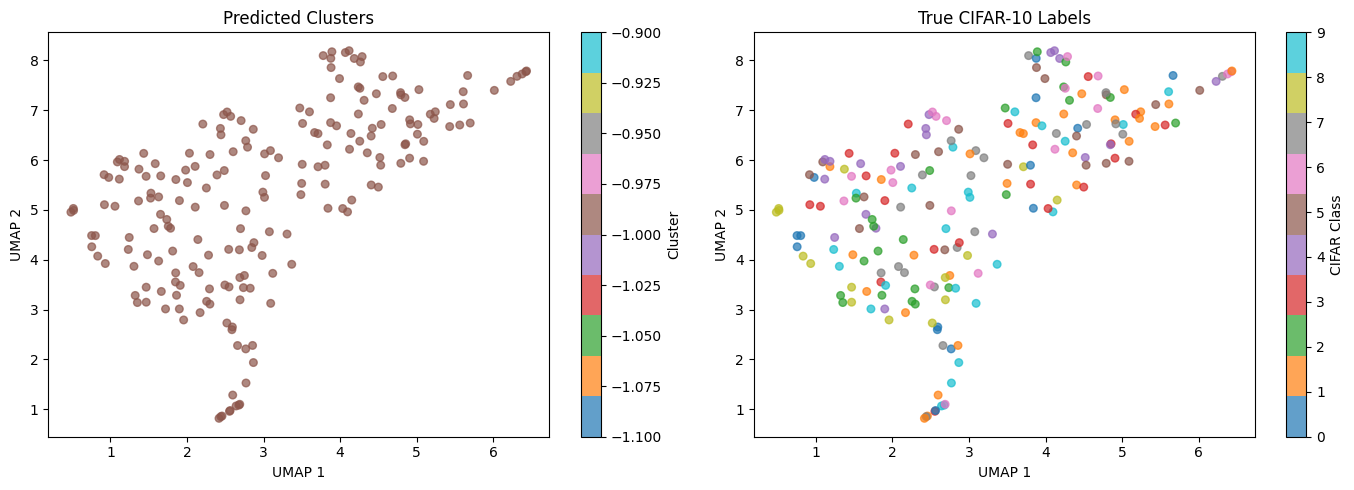

Adjusted Rand Index (clusters vs true labels): 0.0000
Saved image_clusters_artifact.pkl


In [4]:
# Dimensionality reduction and clustering
if embeddings is not None:
    reducer = umap.UMAP(n_components=2, random_state=42)
    emb2 = reducer.fit_transform(embeddings)
    # try HDBSCAN first
    try:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
        labels = clusterer.fit_predict(embeddings)
    except Exception:
        labels = KMeans(n_clusters=6, random_state=42).fit_predict(embeddings)

    print('Cluster label counts:')
    import collections
    print(collections.Counter(labels))

    # silhouette on non-noise points
    try:
        mask = labels != -1
        if mask.sum() > 1:
            print('Silhouette (non-noise):', silhouette_score(embeddings[mask], labels[mask]))
    except Exception as e:
        print('Silhouette error:', e)

    # --- Visualization 1: UMAP 2D scatter plot colored by cluster ---
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(emb2[:, 0], emb2[:, 1], c=labels, cmap='tab10', s=40, alpha=0.8)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Image Clustering - UMAP 2D Projection')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

    # --- Visualization 2: Cluster distribution bar chart ---
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    colors = ['gray' if l == -1 else plt.cm.tab10(l % 10) for l in unique_labels]
    bar_labels = ['Noise' if l == -1 else f'Cluster {l}' for l in unique_labels]
    bars = plt.bar(bar_labels, counts, color=colors)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Images')
    plt.title('Images per Cluster')
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count), ha='center', va='bottom', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Visualization 3: Compare clusters vs true CIFAR labels (if available) ---
    # Extract true labels from filenames (format: {i}_lbl{label}.png)
    true_labels = []
    for p in image_paths[:len(labels)]:
        try:
            fname = os.path.basename(p)
            lbl = int(fname.split('_lbl')[1].split('.')[0])
            true_labels.append(lbl)
        except:
            true_labels.append(-1)
    true_labels = np.array(true_labels)

    if len(np.unique(true_labels)) > 1:
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        scatter1 = plt.scatter(emb2[:, 0], emb2[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
        plt.colorbar(scatter1, label='Cluster')
        plt.title('Predicted Clusters')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')

        plt.subplot(1, 2, 2)
        scatter2 = plt.scatter(emb2[:, 0], emb2[:, 1], c=true_labels, cmap='tab10', s=30, alpha=0.7)
        plt.colorbar(scatter2, label='CIFAR Class')
        plt.title('True CIFAR-10 Labels')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.tight_layout()
        plt.show()

        # Compute ARI between clusters and true labels
        from sklearn.metrics import adjusted_rand_score
        ari = adjusted_rand_score(true_labels, labels)
        print(f'Adjusted Rand Index (clusters vs true labels): {ari:.4f}')

    # --- Visualization 4: Image montage per cluster ---
    unique = np.unique(labels)
    for cl in unique:
        if cl == -1:
            continue
        idxs = np.where(labels==cl)[0][:12]
        print(f'Cluster {cl} (size {len(np.where(labels==cl)[0])}) samples:')
        show_image_grid(image_paths, idxs, n_cols=6)

    # save embeddings and labels
    import joblib
    joblib.dump({'image_paths': image_paths[:200], 'embeddings': embeddings, 'labels': labels}, 'image_clusters_artifact.pkl')
    print('Saved image_clusters_artifact.pkl')
else:
    print('No embeddings available; ensure at least CLIP or ImageBind is installed')